<a href="https://colab.research.google.com/github/Nikita018/Image-Segmentation/blob/master/src/animal_dataset_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installing the examples from TF
pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
!pip install -q pyyaml h5py

In [0]:
# importing the libraries and packages
import tensorflow as tf
import numpy as np
import os
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow import keras

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
# downloading the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [0]:
# normalize function makes the image pixel intensities range between 0 and 1 
# makes the classes of mask range from 0 to n
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
# this function resizes the images to 128 X 128 
# for 50% of the images it flips the images for better generalization of the model
# the input object datapoint is expected to have the image and segmentation_mask
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
# loading the image for test dataset, which won't be part of the tf graph
# there is no flipping required for the test dataset, as we need to evaluate them as it is
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [48]:
# some statistics about the dataset
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print("Train length:", TRAIN_LENGTH)

Train length: 3680


In [0]:
# loading the dataset from the object
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


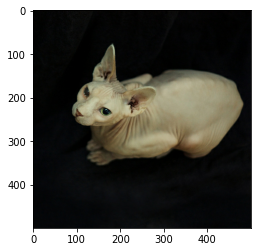

[1 2 3]


In [50]:
# exploring the elements contained in the dataset
for i in dataset['train'].take(1):
  print(i.keys())
  filename=i['file_name']
  image=i['image']
  seg=i['segmentation_mask']
  img=image.numpy()
  plt.imshow(img)
  plt.show()
  seg=seg.numpy()
  print(np.unique(seg))

In [0]:
# shuffling the training dataset randomly and prefetching the training dataset for faster train
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
# this function displays the images 
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
def unet_model(output_channels,down_stack,up_stack):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Define the sequential model
def create_model(base_model,OUTPUT_CHANNELS):
  # building these layers on top the pretrained model

  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
  down_stack.trainable = False
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]
  model = unet_model(OUTPUT_CHANNELS,down_stack,up_stack)

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [54]:
# Model specific details

OUTPUT_CHANNELS = 3
# pretrained MobileNetV2 model from keras applications
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
model = create_model(base_model,OUTPUT_CHANNELS)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Model)                [(None, 64, 64, 96), 1841984     input_16[0][0]                   
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 8, 8, 512)    1476608     model_10[1][4]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential_32[0][0]              
                                                                 model_10[1][3]            

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

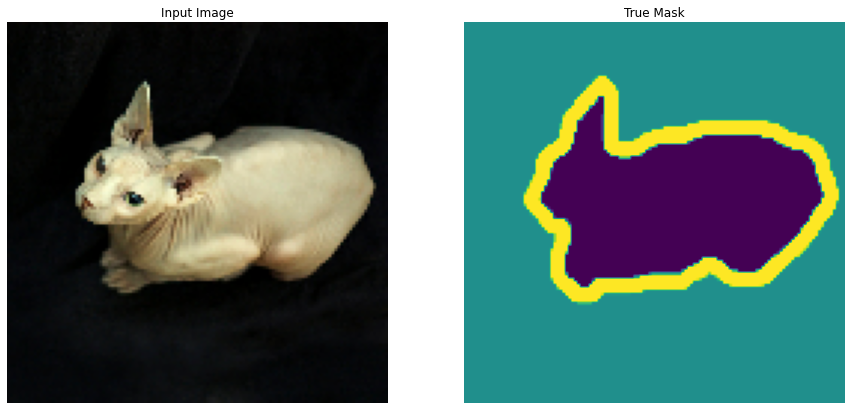

In [56]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [0]:
def show_predictions(dataset=None, num=1,model_to_use=model):
  model=model_to_use
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [75]:
checkpoint_path = "/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_animal/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, frequency = 5)
# Create a basic model instance
model = create_model(base_model,OUTPUT_CHANNELS)
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path)

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[cp_callback])


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.7863
Epoch 00001: saving model to /content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_animal/cp.ckpt
57/57 [==============================] - 292s 5s/step - loss: 0.5305 - accuracy: 0.7863 - val_loss: 0.5204 - val_accuracy: 0.8102
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8763
Epoch 00002: saving model to /content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_animal/cp.ckpt
57/57 [==============================] - 300s 5s/step - loss: 0.3020 - accuracy: 0.8763 - val_loss: 0.3090 - val_accuracy: 0.8796
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8858
Epoch 00003: saving model to /content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_anima

In [76]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_animal/cp.ckpt


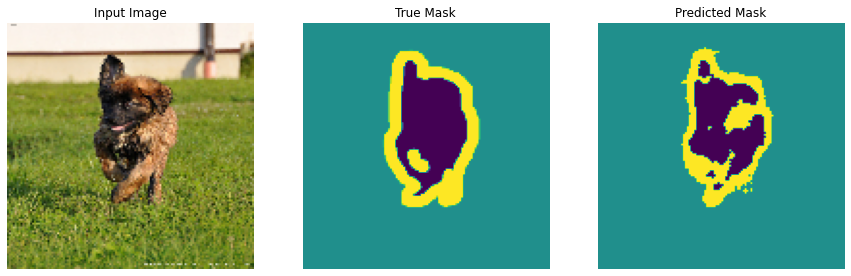

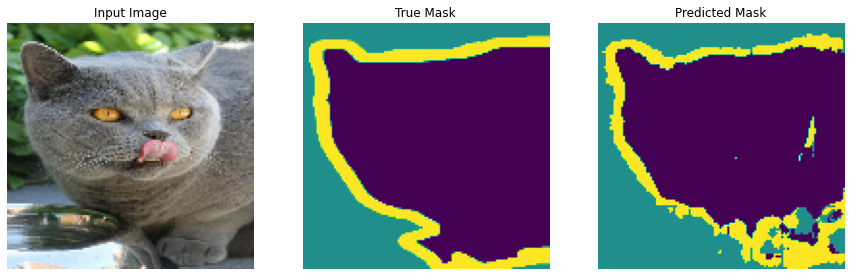

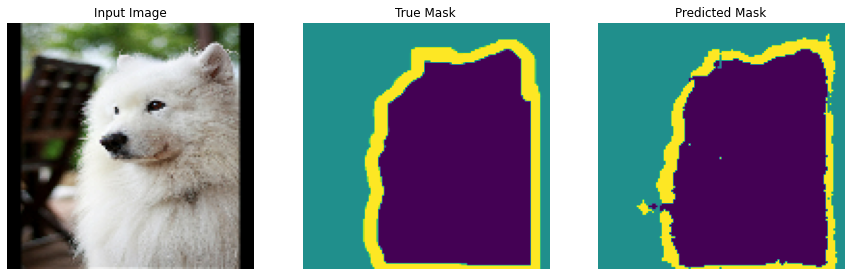

In [77]:
show_predictions(test_dataset, 3,model)

/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights_animal/cp.ckpt


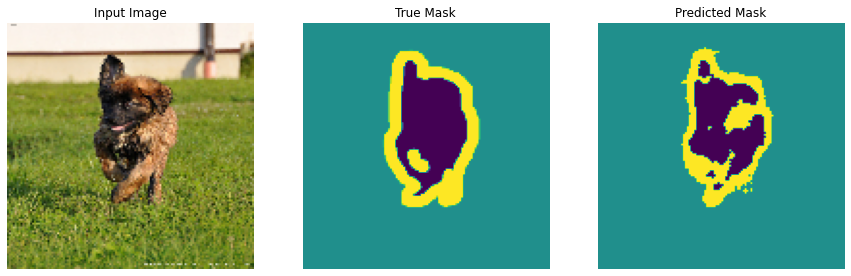

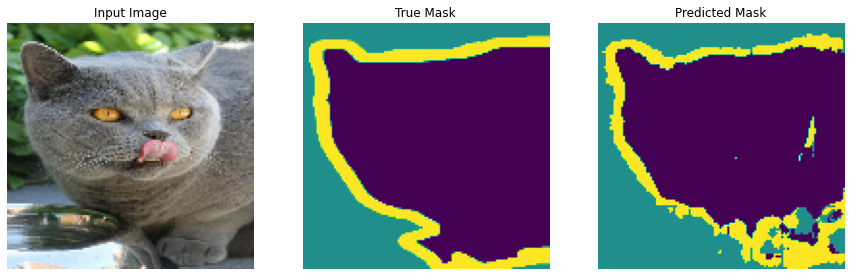

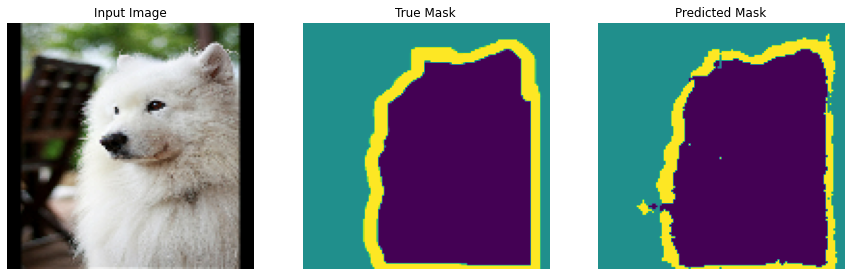

In [78]:
# Create a new model instance
model2 = create_model(base_model,OUTPUT_CHANNELS)

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
model2.load_weights(latest)
show_predictions(test_dataset, 3,model2)

Saving cat.jpg to cat (6).jpg


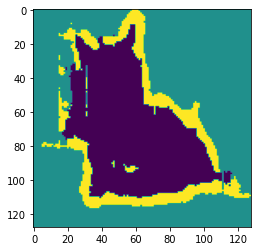

In [94]:
# Upload and Test your own image to see if it's classified as a Road or not

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  test_img=cv2.imread(path,1)
  test_img =cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
  test_img =cv2.resize(test_img,(128,128))
  test_img = tf.cast(test_img, tf.float32) / 255.0
  
  
  # x = image.img_to_array(img)
  x = np.expand_dims(test_img, axis=0)
  pred=model.predict(x)
  pred_0=pred[0]
  # pred_0=pred[0]
  pred_max=np.zeros((pred_0.shape[0],pred_0.shape[1]))
  for i in range(pred_0.shape[0]):
    for j in range(pred_0.shape[1]):
      if pred_0[i,j,0]>pred_0[i,j,1] and pred_0[i,j,0]>pred_0[i,j,2]:
        pred_max[i,j]=0
      elif pred_0[i,j,1]>pred_0[i,j,0] and pred_0[i,j,1]>pred_0[i,j,2]:
        pred_max[i,j]=1
      else:
        pred_max[i,j]=2
  plt.imshow(pred_max)
  plt.show()